# <center>Direct numerical simulation of transitional boundary layer with a fluid at supercritical pressure</center>

             Created on: May 20, 2025
           Developed by: Pietro Carlo Boldini (pietro.c.boldini@gmail.com)
                         Rene Pecnik (r.pecnik@tudelft.nl)
                         Process & Energy Department, Faculty of 3mE
                         Delft University of Technology, the Netherlands.

       Last modified on: May 21, 2025


The following python code in this notebook is based on the publication: 


This is the bibtex entry in case you use the code: 

# Main source code
<br>
<hr style="border:0.5px solid black">


## Mean velocity profile
The mean velocity is obtained by 

$$ \bar u^+ = 
\int_{0}^{\delta^+} 
\left[\vphantom{\frac{1}{2}}\right.
\underbrace{\frac{\mu_w}{\bar \mu + \mu_t}}_{\text{Law of the wall}}
+  
\underbrace{\frac{\sqrt{\rho_w/\bar\rho}}{Re_\tau} \, \frac{\Pi}{\kappa} \, \pi\, \sin \left(\pi \frac{y}{\delta}\right)}_{\text{Law of the wake}}
\left.\vphantom{\frac{1}{2}}\right]
dy^+, $$

with the Johnson-King eddy eddy viscosity model, defined as 

$$\mu_t = \kappa \bar\mu y^* D(M_\tau), $$

and the modified van Driest damping function

$$ D(M_{\tau}) = \left[1 - \mathrm{exp}\left({\frac{-y^*}{A^+ + f(M_\tau)}}\right)\right]^2. $$

The constants and the function to account for intrinsic compressiblity effects in $D$ are given as

$$A^+ = 17,~\kappa=0.41,~\text{and}~f(M_\tau)=19.3M_\tau,~\text{where}~M_\tau=u_{\tau,w}/a_w .$$

The wake parameter is obtained by 

$${\Pi} = 0.69\,\left[1 - \exp(-0.243 \sqrt{z} - {0.15} \,z)\right],$$
with
$$z = \max(0,Re_\theta/425 - 1).$$

In [1]:
def meanVelocity(ReTheta, ReTau, MTau, y_ye, r_rw, mu_muw, kappa, Apl):
    
    # Semi-local Reynolds number and scaled wall distances 
    ReTauSt = ReTau*np.sqrt(r_rw)/mu_muw
    ypl     = y_ye*ReTau
    yst     = y_ye*ReTauSt
    
    # eddy viscosity model
    D    = (1-np.exp(-yst/(Apl + 19.3*MTau)))**2
    mut  = kappa*mu_muw*yst*D
    
    # wake parameter
    z1   = max(0, ReTheta/425-1)
    Pi   = 0.69*(1 - np.exp(-0.243*z1**0.5 - 0.150*z1))
    Wake = Pi/kappa*np.pi*np.sin(np.pi*y_ye)
    
    # velocity 
    upl  = cumulative_trapezoid(1/(mu_muw + mut) + 1/ReTau/np.sqrt(r_rw)*Wake, ypl, initial=0)
    
    upl_inf = upl[-1]/0.99 # calculate upl_inf

    return ypl, yst, upl, upl_inf

# Enthalpy-velocity relationships

### Walz (Walz, MIT Press, 1969):

$$ \dfrac{\overline{h}}{h_\infty}=\dfrac{h_\mathit{w}}{h_\infty}+\dfrac{\overline{h}_\mathit{r}-h_\mathit{w}}{h_\infty}\left(\dfrac{\overline{u}}{u_\infty}\right) -r\dfrac{u^2_\infty}{2h_\infty}\left(\dfrac{\overline{u}}{u_\infty}\right)^2, $$
with recovery factor $r=(Pr_\infty)^{1/3}$.

### Duan & Martín (Duan & Martin, JFM, 2011):

$$ \dfrac{\overline{h}}{h_\infty}=\dfrac{h_\mathit{w}}{h_\infty}+\dfrac{\overline{h}_\mathit{r}-h_\mathit{w}}{h_\infty}\left[ 0.1741\left(\dfrac{\overline{u}}{u_\infty}\right)^2+0.8259\left(\dfrac{\overline{u}}{u_\infty}\right)\right] -r\dfrac{u^2_\infty}{2h_\infty}\left(\dfrac{\overline{u}}{u_\infty}\right)^2, $$
with recovery factor $r=(Pr_\infty)^{1/3}$.



In [3]:
def meanEnthalpy(u_uinf,hinf_hw,hrec_hw,Pinf,Rhoref,Tref,Href,Cvref,Zc,Tw_Tinf,rw_rinf,entvelLaw):
    if entvelLaw == "Walz":
        h_hw = 1 + (hrec_hw - 1) * (u_uinf) +  (hinf_hw-hrec_hw)*(u_uinf)**2  
    elif entvelLaw == "DuanMartin":
        alpha=0.8259
        h_hw = 1 + (hrec_hw - 1) * u_uinf * ((1 - alpha) * (u_uinf) + alpha) +  (hinf_hw-hrec_hw)*(u_uinf)**2 
    else:
        print('Enthlapy-velocity rel. ', entvelLaw, " not available")
    
    # Calculate T and rho from enthalpy
    hr = h_hw*Href/hinf_hw
    cvr = Cvref          
    pr = Pinf
    def make_equations(hr_val): 
        def equations(vars):
            Tr, vr = vars
            eq1 = hr_val - (cvr / Zc) * Tr + 3 / vr - pr * vr
            eq2 = pr - (8 * Tr) / (3 * vr - 1) + 3 / vr**2
            return [eq1, eq2]
        return equations

    solutions = []
    for hr_val in hr:
        sol = fsolve(make_equations(hr_val), [Tref, 1/Rhoref])  # Initial guess
        solutions.append(sol)

    solutions = np.array(solutions)
    Tr, rhor = solutions[:,0], 1./solutions[:,1]
    
    T_Tw = Tr/Tref/Tw_Tinf
    r_rw = rhor/Rhoref/rw_rinf
    
    return h_hw,T_Tw,r_rw

# Calculation of VdW EoS relevant parameters 

Reduced density $\rho_r$: solve the cubic equation for specific volume $\upsilon_r=1/\rho_r$
$$ p_\mathit{r}=\dfrac{8T_\mathit{r}}{3\upsilon_r-1} - \dfrac{3}{\upsilon^2_r}, $$
with $T_r=T_{ref}$ and $p_r=p_{ref}$.

Reduced enthalpy $h_r$: 
$$ h_r=e_r +\frac{p_r}{\rho_r}, \quad e_\mathit{r}=\dfrac{c_\mathit{\upsilon,r}T_\mathit{r}}{Z_\mathit{c}} -3\rho_\mathit{r}, $$
with $Z_c=3/8$ (Van der Waals EoS) and $c_\mathit{\upsilon,r}=c_{\upsilon,ref}$.

Reduced speed of sound $a_r$:
$$ a^2_r=\left(1+\dfrac{1}{c_{\upsilon,r}}\right)\dfrac{1}{c_{\upsilon,r}} \left(e_r +\dfrac{3}{\upsilon_r} \right)\left(\dfrac{3\upsilon_r}{3\upsilon_r-1}\right)^2-\dfrac{6}{\upsilon_r}. $$

Reduced recovery enthalpy:
$$ h_{r,rec}=h_{r,\infty}+\dfrac{r}{2}M^2_\infty a^2_{r,\infty}, $$
with recovery factor $r=(Pr_\infty)^{1/3}$.

In [4]:
def calc_VdW(Tw_Tinf,rw_rinf,Pref,Tref,Cvref,Minf,rec):
    
    Zc = 3/8
    # Reference parameters in reduced form
    if Tref < 1.0:
        Rho_guess = 2.0
    elif Tref > 1.0:
        Rho_guess = 0.5
        
    sol_v = solve_volume(Pref,Rho_guess,Tref)
    Rhoref = 1/sol_v
    Href = (Cvref / Zc) * Tref - 3*Rhoref + Pref/Rhoref
    Aref = ( (1+1/Cvref)*Tref/Zc*(3*sol_v/(3*sol_v-1))**2-6/sol_v )**0.5
    
    # Recovery enthalpy
    cvr = Cvref     
    pr = Pref
    Tr = Tw_Tinf*Tref
    rhor = rw_rinf*Rhoref
    hr = (cvr / Zc) * Tr - 3*rhor + pr/rhor
    hw_hinf = hr/Href
    hinf_hw = 1/hw_hinf 
    hrec_hinf = 1 + 0.5*rec*Minf**2*Aref**2/Href
    hrec_hw = hrec_hinf*hinf_hw
    hw_hr = 1/hinf_hw/hrec_hinf
    
    return Rhoref,Href,Aref,Zc,hrec_hw,hinf_hw,hw_hr

# Help function to calculate the specific volume from pressure and temperature
def solve_volume(Pinf, Rhoref, T1D):
    
    # Function to solve the cubic equation
    def van_der_waals(v, p, T):
        return (8 * T) / (3 * v - 1) - 3 / v**2 - p

    # Check if input is scalar
    is_scalar = np.isscalar(T1D)
    
    # Ensure T1D is at least 1D
    T_array = np.atleast_1d(T1D)
    
    # Allocate output array
    sol_v = np.zeros_like(T_array)
    
    # Initial guess for volume
    v_guess = 1 / Rhoref
    
    for i, T in enumerate(T_array):
        sol_v[i] = fsolve(van_der_waals, v_guess, args=(Pinf, T))[0]
    
    # Return scalar if input was scalar, else array
    return sol_v[0] if is_scalar else sol_v

## Calculation of density from the VdW EoS

Solve the cubic equation for specific volume $\upsilon_r$:
$$ p_\mathit{r}=\dfrac{8T_\mathit{r}}{3\upsilon_r-1} - \dfrac{3}{\upsilon^2_r} $$

In [5]:
def density(T_Tw,Pinf,Rhoref,Tref,Tw_Tinf,rw_rinf):
    Tr=T_Tw*Tref*Tw_Tinf
    sol_v = solve_volume(Pinf,Rhoref*rw_rinf,Tr)
    r_rw=1/sol_v/Rhoref/rw_rinf
    return r_rw

# Calculation of transport properties

### Dynamic viscosity $\mu^*$ with the JST (Jossi-Stiel-Thodos) model:
$$		\left[ (\mu^*-\mu^*_0) \xi^* + 10^{-4} \right]^{1/4}=0.10230+0.023364\rho_r+0.058533\rho^2_r-0.040758\rho^3_r+0.0093324\rho^4_r, \quad \rho_r=\dfrac{\rho^*}{\rho^*_c} $$
where $\xi^*$ is the viscosity parameter as
$$ \xi^*=\dfrac{T^{*1/6}_c \times 10^{3}}{M^{*1/2} \ p^{*2/3}_c}  $$
and $\mu^*_0$ is the viscosity at normal pressures as
$$
\mu_0^* \xi^* =
\begin{cases}
34 \times 10^{-5} \, T_r^{0.94}, & \text{if } T_r \leq 1.50 \\
17.78 \times 10^{-5} \left( 4.58 T_r - 1.67 \right)^{5/8}, & \text{if } T_r > 1.50
\end{cases}
$$
with $T_r=\dfrac{T^*}{T^*_c}$. Here:
$$
		\mu=\dfrac{\mu^*}{\mu^*_w}=\dfrac{\mu^* \xi^*}{(\mu^* \xi^*)_w} = \dfrac{f(\rho_r) +\mu^*_0\xi^*}{(f(\rho_r) +\mu^*_0\xi^*)_w}
$$

### Thermal conductivity $\kappa^*$ with the JST (Jossi-Stiel-Thodos) model:
$$ (\kappa^*-\kappa^*_0) \lambda^*  Z_c^5  = f(\rho_r) =\dfrac{4.1868}{10^{-2}} 
\begin{cases}
14.0 \left[ \exp(0.535 \rho_r) -1  \right] \times 10^{-8}, \quad \rho_r<0.50 \\
13.1 \left[ \exp(0.67 \rho_r) -1.069  \right] \times 10^{-8}, \quad 0.50 \leq \rho_r \leq 2.00 \\
2.976 \left[ \exp(1.155 \rho_r) + 2.016  \right] \times 10^{-8}. \quad 2.00 < \rho_r \leq 2.80 \\
\end{cases}	 
$$

where $\lambda^*$ is the thermal conductivity parameter as
$$ \lambda^*=\dfrac{M^{*1/2} \ T^{*1/6}_c}{ \ p^{*2/3}_c} =\xi^* M^* $$

and $\kappa^*_0$ is the thermal conductivity at atmospheric pressures of a polyatomic gas as
$$ \kappa^*_0=\left(0.307 \dfrac{c^{*}_\upsilon}{R^*_g} + 0.539 \right) \kappa^*_{0,m}, \quad c_{\upsilon,ref}=\dfrac{c^{*}_\upsilon}{R^*_g}. $$

with $\kappa^*_{0,m}$, following Hirschfelder et al. (Molecular Theory of Gases and Liquids, Wiley, 1954), as
$$\kappa^*_{0,m}=\dfrac{15}{4}\dfrac{R^*_0}{M^*} \mu^*_{0,m}.$$

It results
$$ \kappa^*\lambda^*=\dfrac{f(\rho_r)}{Z^5_c} + \left(0.307 \dfrac{c^{*}_\upsilon}{R^*_g} + 0.539 \right) \dfrac{15}{4} R^*_0 \mu^*_{0,m} \xi^* $$
where $\mu^*_{0,m} \xi^*$ is calculated from above. Here
$$ \kappa=\dfrac{\kappa^*}{\kappa^*_w}=\dfrac{\kappa^* \lambda^*}{(\kappa^* \lambda^*)_w} = \dfrac{\dfrac{f(\rho_r)}{Z^5_c} +F\left(\dfrac{c^{*}_\upsilon}{R^*_g},\mu^*_{0,m} \xi^*\right)}{\left(\dfrac{f(\rho_r)}{Z^5_c} +F\left(\dfrac{c^{*}_\upsilon}{R^*_g},\mu^*_{0,m} \xi^*\right)\right)_w}. $$

## Prandtl number:

$$ Pr=\frac{c_p \mu}{\kappa}$$

with the reduced isobaric specific heat $c_{p,r}$ as

$$ c_{p,r}=\frac{c^*_p}{R^*_g}=c_{\upsilon,ref}+\left[1-\frac{\rho_r(3-\rho_r)^2}{4T_r}\right]^{-1}.$$


In [6]:
def transport_prop(T_Tw,r_rw,Rhoref,Tref,Cvref,Zc,Tw_Tinf,rw_rinf):
    Ru   = 8.31451
    T_Tw = T_Tw*Tref*Tw_Tinf        # to reduced properties
    r_rw = r_rw*Rhoref*rw_rinf      # to reduced properties
    
    # Calculate dynamic viscosity
    mu_1 = np.zeros_like(T_Tw)
    f_rho = np.zeros_like(r_rw)
    mu_diff = np.zeros_like(r_rw)
    mu = np.zeros_like(r_rw)
    for i in range(len(T_Tw)):
        if T_Tw[i] <= 1.50:
            mu_1[i] = 34 * 10**(-5) * T_Tw[i]**0.94
        else:
            mu_1[i] = 17.78 * 10**(-5) * (4.58 * T_Tw[i] - 1.67)**(5/8)
    for i in range(len(T_Tw)):
        f_rho[i] = (0.10230 + 0.023364 * r_rw[i] +
                    0.058533 * r_rw[i]**2 -
                    0.040758 * r_rw[i]**3 +
                    0.0093324 * r_rw[i]**4)
        mu_diff[i] = f_rho[i]**4 - 10**(-4)
        mu[i] = mu_diff[i] + mu_1[i]
    mu_muw=mu/mu[0]
    
    # Calculate thermal conductivity
    kappa_factor = (0.307 * Cvref + 0.539)
    kappa_EU = np.zeros_like(mu_1)
    for i in range(len(T_Tw)):
        kappa_EU[i] = (15 / 4) * Ru * mu_1[i] * kappa_factor
    
    f_rho_2 = np.zeros_like(r_rw)
    f_rho_3 = np.zeros_like(r_rw)
    kappa_diff = np.zeros_like(r_rw)
    ka = np.zeros_like(r_rw)
    for i in range(len(T_Tw)):
        if r_rw[i] < 0.50:
            f_rho[i] = 14.0 * (np.exp(0.535 * r_rw[i]) - 1)
            kappa_diff[i] = (f_rho[i] * 1e-8) / Zc**5
        elif 0.50 <= r_rw[i] < 2.0:
            f_rho_2[i] = 13.1 * (np.exp(0.67 * r_rw[i]) - 1.069)
            kappa_diff[i] = (f_rho_2[i] * 1e-8) / Zc**5
        else:
            f_rho_3[i] = 2.976 * (np.exp(1.155 * r_rw[i]) + 2.016)
            kappa_diff[i] = (f_rho_3[i] * 1e-8) / Zc**5
        
        ka[i] = kappa_diff[i] * (4.1868 / 1e-2) + kappa_EU[i]  
    ka_kaw=ka/ka[0]
    
    # Calculate Prandtl number  
    cp_cpw = Cvref+1/(1-(3/r_rw-1)**2/(4*T_Tw*(1/r_rw)**3))
    Pr = cp_cpw*mu_muw/ka_kaw/cp_cpw[-1]
    Pr = Pr/Pr[-1]
    
    r_rw=r_rw/Rhoref/rw_rinf
    T_Tw=T_Tw/Tref/Tw_Tinf

    return mu_muw,ka_kaw,Pr

# Compute $c_f$, $c_h$, and $Re_\tau$, $M_\tau$ based on the inputs $Re_\theta$ and $M_\infty$

Skin friction coefficient 
$$c_f = \frac{2 \tau_w}{\rho_\infty u_\infty^2}. $$

Stanton number (obtained by the non-dimensional wall heat flux)

$$q_w \approx \frac{1}{Re_\tau Pr_w} \frac{\partial T}{\partial y}\bigg|_w. $$

$$St = \frac{q_w}{\rho_\infty u_\infty (M_\infty a_{r,\infty})^2 (1-h_r/h_w)}.$$

Relation between $Re_\tau$ and $Re_\theta$ 

$$Re_\tau = {Re_\theta}\frac{ \mu_\infty/\mu_w}{(\rho_\infty/\rho_w) u_\infty^+ (\theta/\delta)}.$$

Relation between $M_\tau$ and $M_\infty$ 

$$M_\tau = M_\infty \sqrt{\frac{c_f}{2}}.$$

In [7]:
def calcParameters(ReTheta, ReTau, Minf, y_ye, T_Tw, h_hw, hw_hr, r_rw, mu_muw, upl, uinf, Pr, Aref):
    rinf  = r_rw[-1]
    muinf = mu_muw[-1] 
    
    # Calculate skin-friction coefficient
    cf    = 2/(rinf*uinf**2) 
    # Calculate Stanton number
    qw = 1/ReTau/Pr[0]*(T_Tw[1]-T_Tw[0])/h_hw[0]/y_ye[1]
    deno = r_rw[-1]*uinf*(1-1/hw_hr)*(Minf*Aref)**2 
    St = abs(qw/deno) if hw_hr != 1 else np.nan  # set St to NaN for adiabatic boundary layers
        
    Theta = trapezoid(r_rw/rinf*upl/uinf*(1 - upl/uinf), y_ye)
    ReTau = ReTheta/(rinf*uinf*Theta/muinf)
    MTau  = Minf*np.sqrt(cf/2)

    return cf, St, ReTau, MTau 

## Distribution of points in wall normal direction
Here we use a tanhyp function with clustering/stretching at the wall

In [8]:
def grid(nPoints = 1000, stretch = 4):
    
    H = 1.0       # --> y/y_e = 1
    tanhyp = 0.5  # half hyp tangens
    i = tanhyp*(np.arange(0,nPoints))/(nPoints-1) - 0.5
    y = 1./tanhyp*H * (1.0 + np.tanh(stretch*i)/np.tanh(stretch/2))/2.0
    
    return y

## Iterative solver

Iterate velocity and enthalpy profiles until friction Reynolds number converges

Required inputs are:
- $Re_\theta$, Reynolds number based on momentum thickness
- $M_\infty$, free-stream Mach number
- $Pr_\infty$ free-stream Prandtl number
- $T_w/T_\infty$  wall-to-infinity temperature ratio
- $\rho_w/\rho_\infty$  wall-to-infinity density ratio
- $p_{ref}$ ($p_\infty/p_c$) free-stream reduced pressure
- $T_{ref}$ ($T_\infty/T_c$) free-stream reduced temperature
- $c_{\upsilon,ref}$ ($c_{\upsilon,\infty}/R_g$) free-stream isochoric specific heat
- Enthalpy-velocity relation: "Walz" (Walz, MIT Press, 1969) or "DuanMartin" (Duan & Martin, JFM, 2011)

Reduced quantities are meant with respect to the thermodynamic critical point $(\cdot)_c$: $(\cdot)_{ref}=\frac{(\cdot)}{(\cdot)_c}$

In [9]:
import numpy as np
from scipy.optimize import fsolve

try:
    from scipy.integrate import trapezoid, cumulative_trapezoid
except ImportError:
    from scipy.integrate import trapz as trapezoid
    from scipy.integrate import cumtrapz as cumulative_trapezoid

In [10]:
                                           #  DEFAULT VALUES FOR:
def cfSt_solver(ReTheta   = 1000,          #  Reynolds number based on momentum thickness
                Minf      = 1.0,           #  Mach number
                kappa     = 0.41,          #  Karman constant
                Apl       = 17.0,          #  Van Driest damping constant
                y_ye      = grid(),        #  grid points in y/ye (from 0 to 1)
                Tw_Tinf   = 1.0,           #  Wall-to-infinity temperature ratio
                rw_rinf   = 1.0,           #  Wall-to-infinity density ratio
                Prinf     = 1.0,           #  Free-stream Prandtl number
                Pref      = 1.0,           #  Free-stream reduced pressure
                Tref      = 1.0,           #  Free-stream reduced temperature
                Cvref     = 1.0,           #  Free-stream isochoric specific heat
                entvelLaw = 'Walz',        #  Enthalpy-velocity relationship
                verbose   = False):        # if True: print iteration residuals
    
    # set initial values for ReTau = 500, MTau = 0.1, and upl = 0.01
    ReTau = 500
    MTau  = 0.1
    upl   = np.ones_like(y_ye)*0.01
    uinf  = upl[-1]*0.99
    T_Tw  = np.ones_like(y_ye)

    rec   = Prinf**(1/3)
    Rhoref,Href,Aref,Zc,hrec_hw,hinf_hw,hw_hr = calc_VdW(Tw_Tinf,rw_rinf,Pref,Tref,Cvref,Minf,rec)

    niter = 0
    err   = 1e10
    
    while(err > 1e-6 and niter < 1000):

        ReTauOld = ReTau

        r_rw                     = density(T_Tw,Pref,Rhoref,Tref,Tw_Tinf,rw_rinf)
        h_hw,T_Tw,r_rw           = meanEnthalpy(upl/uinf,hinf_hw,hrec_hw,Pref,Rhoref,Tref,Href,Cvref,Zc,Tw_Tinf,rw_rinf,entvelLaw)     
        mu_muw,ka_kaw,Pr         = transport_prop(T_Tw,r_rw,Rhoref,Tref,Cvref,Zc,Tw_Tinf,rw_rinf)
        ypl, yst, upl, uinf      = meanVelocity(ReTheta, ReTau, MTau, y_ye, r_rw, mu_muw, kappa, Apl)
        cf, St, ReTau, MTau      = calcParameters(ReTheta, ReTau, Minf, y_ye, T_Tw, h_hw, hw_hr, r_rw, mu_muw, upl, uinf, Pr, Aref)  
       
        err = abs(ReTauOld-ReTau)
        niter += 1
        
        if verbose == True:
            if niter==1:
                print('{0:>5}{1:>14}{2:>14}{3:>14}{4:>14}{5:>14}{6:>14}'.format('iter','err','cf','St','ReTheta','ReTau','MTau'))
            print('{0:>5}{1:14.4e}{2:14.4e}{3:14.4e}{4:14.4f}{5:14.4f}{6:14.4e}'.format(niter, err, cf, St, ReTheta, ReTau, MTau))

    return cf, St, ReTau, MTau, ypl, yst, upl, T_Tw, r_rw, h_hw, mu_muw, ka_kaw

# <br>
<br>
<br>

# Examples 
<br>

<hr style="border:0.5px solid black">

## Boundary layer with $M_\infty=0.2$, $Re_\theta =1387$, $Pr_\infty=1.0$, $P_{ref}=1.1$  and $T_{ref}=0.9$ at subcritical conditions $T_w/T_\infty= 1.056$, $\rho_w/\rho_\infty= 0.909$

 iter           err            cf            St       ReTheta         ReTau          MTau
    1    1.5312e+01    3.7487e-03    0.0000e+00     1387.0000      515.3121    8.6588e-03
    2    9.3528e+01    3.7787e-03    1.6774e-03     1387.0000      608.8403    8.6933e-03
    3    5.5790e+00    3.6396e-03    1.4403e-03     1387.0000      603.2613    8.5319e-03
    4    2.2483e-01    3.6540e-03    1.6889e-03     1387.0000      603.4861    8.5486e-03
    5    2.8931e-03    3.6532e-03    1.6759e-03     1387.0000      603.4832    8.5477e-03
    6    3.8516e-04    3.6532e-03    1.6763e-03     1387.0000      603.4828    8.5478e-03
    7    4.0385e-05    3.6532e-03    1.6763e-03     1387.0000      603.4829    8.5478e-03
    8    2.2924e-06    3.6532e-03    1.6763e-03     1387.0000      603.4829    8.5478e-03
    9    7.8299e-08    3.6532e-03    1.6763e-03     1387.0000      603.4829    8.5478e-03

Result: cf = 3.65321e-03, St = 1.67633e-03, ReTau = 603.48288, MTau = 8.548e-03


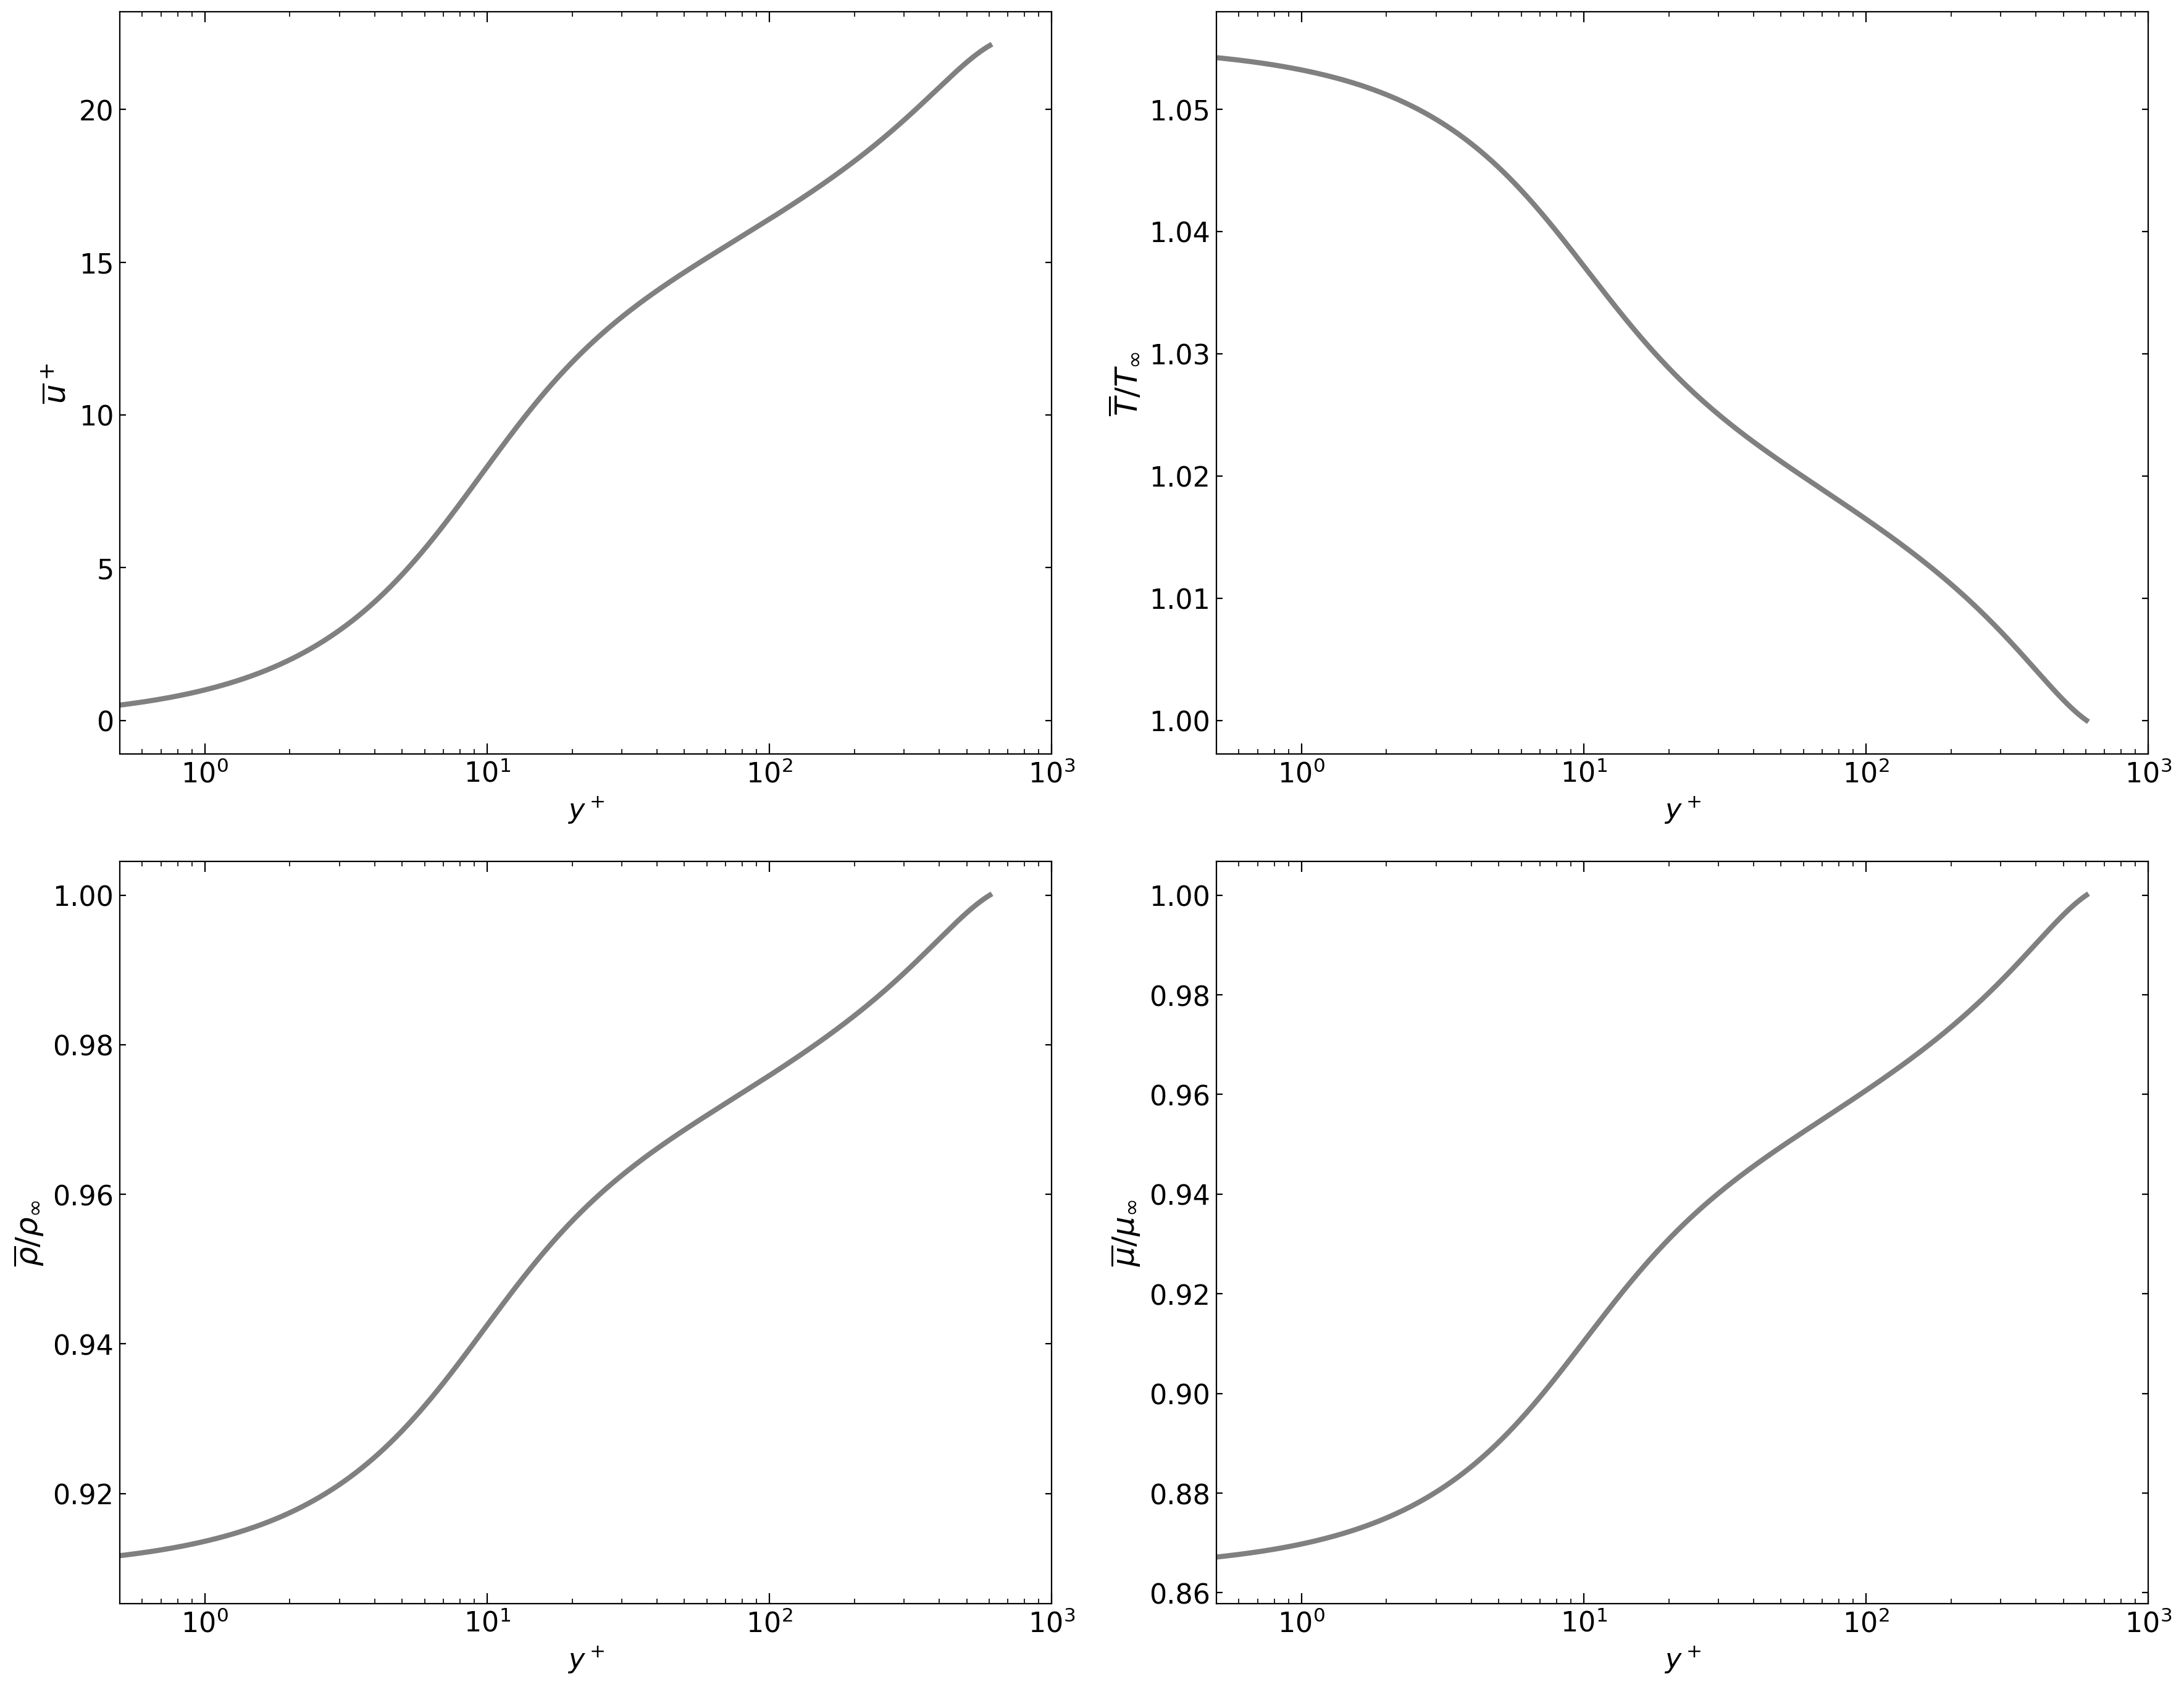

In [11]:
ReTheta        = 1387
Minf           = 0.2
Prinf          = 1.0
Tw_Tinf        = 1.056
rw_rinf        = 0.909 
Pref           = 1.10   
Tref           = 0.9
Cvref          = 4.5
entvelLaw      = "Walz"

cf, St, ReTau, MTau, ypl, yst, upl, T_Tw, r_rw, h_hw, mu_muw, ka_kaw  = \
                cfSt_solver(ReTheta   = ReTheta,
                            Minf      = Minf,
                            kappa     = 0.41,
                            Apl       = 17.0,
                            y_ye      = grid(nPoints = 2000, stretch = 5),
                            Tw_Tinf   = Tw_Tinf,
                            rw_rinf   = rw_rinf,
                            Prinf     = Prinf,
                            Pref      = Pref,
                            Tref      = Tref,
                            Cvref     = Cvref,
                            entvelLaw = entvelLaw,
                            verbose   = True)  

print('\nResult: cf = {0:.5e}, St = {1:.5e}, ReTau = {2:.5f}, MTau = {3:.3e}'.
      format(cf, St, ReTau, MTau))

#################################################################################
#
# plot profiles
#
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
import matplotlib.ticker as ticker
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
rc('text', usetex=False)  # switch to True for latex font (might be slow)
rcParams.update({"xtick.major.size": 6, "xtick.minor.size": 3, "ytick.minor.size": 6, "ytick.minor.size": 3, 
                 'xtick.direction': 'in', 'ytick.direction': 'in', 'xtick.top': True, 'ytick.right': True, 
                 'font.size': 16})

fig, ax = plt.subplots(2, 2, figsize=(18, 14))
plt.rcParams["text.usetex"] = True
linwid=3.0
ylim=1e3
ax[0,0].semilogx(ypl, upl, '-', lw=linwid, color='gray')
ax[0,0].set_xlim(0.5e0, ylim)
ax[0,0].set_ylabel(r"$\overline{u}^+$",  fontsize = 18)
ax[0,0].set_xlabel(r"$y^+$")

ax[0,1].semilogx(ypl, T_Tw/T_Tw[-1], '-', lw=linwid, color='gray')
ax[0,1].set_xlim(0.5e0, ylim)
ax[0,1].set_ylabel(r"$\overline{T}/T_{\infty}$",  fontsize = 18)
ax[0,1].set_xlabel(r"$y^+$")

ax[1,0].semilogx(ypl, r_rw/r_rw[-1], '-', lw=linwid, color='gray')
ax[1,0].set_xlim(0.5e0, ylim)
ax[1,0].set_ylabel(r"$\overline{\rho}/\rho_{\infty}$",  fontsize = 18)
ax[1,0].set_xlabel(r"$y^+$")

ax[1,1].semilogx(ypl, mu_muw/mu_muw[-1], '-', lw=linwid, color='gray')
ax[1,1].set_xlim(0.5e0, ylim)
ax[1,1].set_ylabel(r"$\overline{\mu}/\mu_{\infty}$",  fontsize = 18)
ax[1,1].set_xlabel(r"$y^+$")

fig.tight_layout()
plt.show()

## Boundary layer with $M_\infty=0.2$, $Re_\theta =881$, $Pr_\infty=1.0$, $P_{ref}=1.1$  and $T_{ref}=0.9$ at transcritical conditions $T_w/T_\infty= 1.222$, $\rho_w/\rho_\infty= 0.321$

 iter           err            cf            St       ReTheta         ReTau          MTau
    1    2.9689e+02    3.5277e-03    0.0000e+00      881.0000      203.1074    8.3997e-03


/opt/homebrew/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/opt/homebrew/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


    2    4.7891e+02    3.6277e-03    1.4424e-02      881.0000      682.0168    8.5179e-03
    3    2.6507e+01    1.9564e-03    1.2926e-03      881.0000      655.5096    6.2552e-03
    4    3.1185e+01    2.3262e-03    3.6150e-03      881.0000      624.3247    6.8209e-03
    5    5.7858e+00    2.3493e-03    3.9970e-03      881.0000      630.1105    6.8547e-03
    6    1.6188e-01    2.3211e-03    3.7679e-03      881.0000      629.9486    6.8134e-03
    7    3.0109e-01    2.3262e-03    3.7850e-03      881.0000      629.6475    6.8208e-03
    8    7.4158e-02    2.3264e-03    3.7901e-03      881.0000      629.7217    6.8211e-03
    9    2.5465e-03    2.3261e-03    3.7878e-03      881.0000      629.7191    6.8207e-03
   10    3.2635e-03    2.3261e-03    3.7881e-03      881.0000      629.7159    6.8208e-03
   11    8.8648e-04    2.3261e-03    3.7881e-03      881.0000      629.7168    6.8208e-03
   12    4.1813e-05    2.3261e-03    3.7881e-03      881.0000      629.7167    6.8208e-03
   13    3

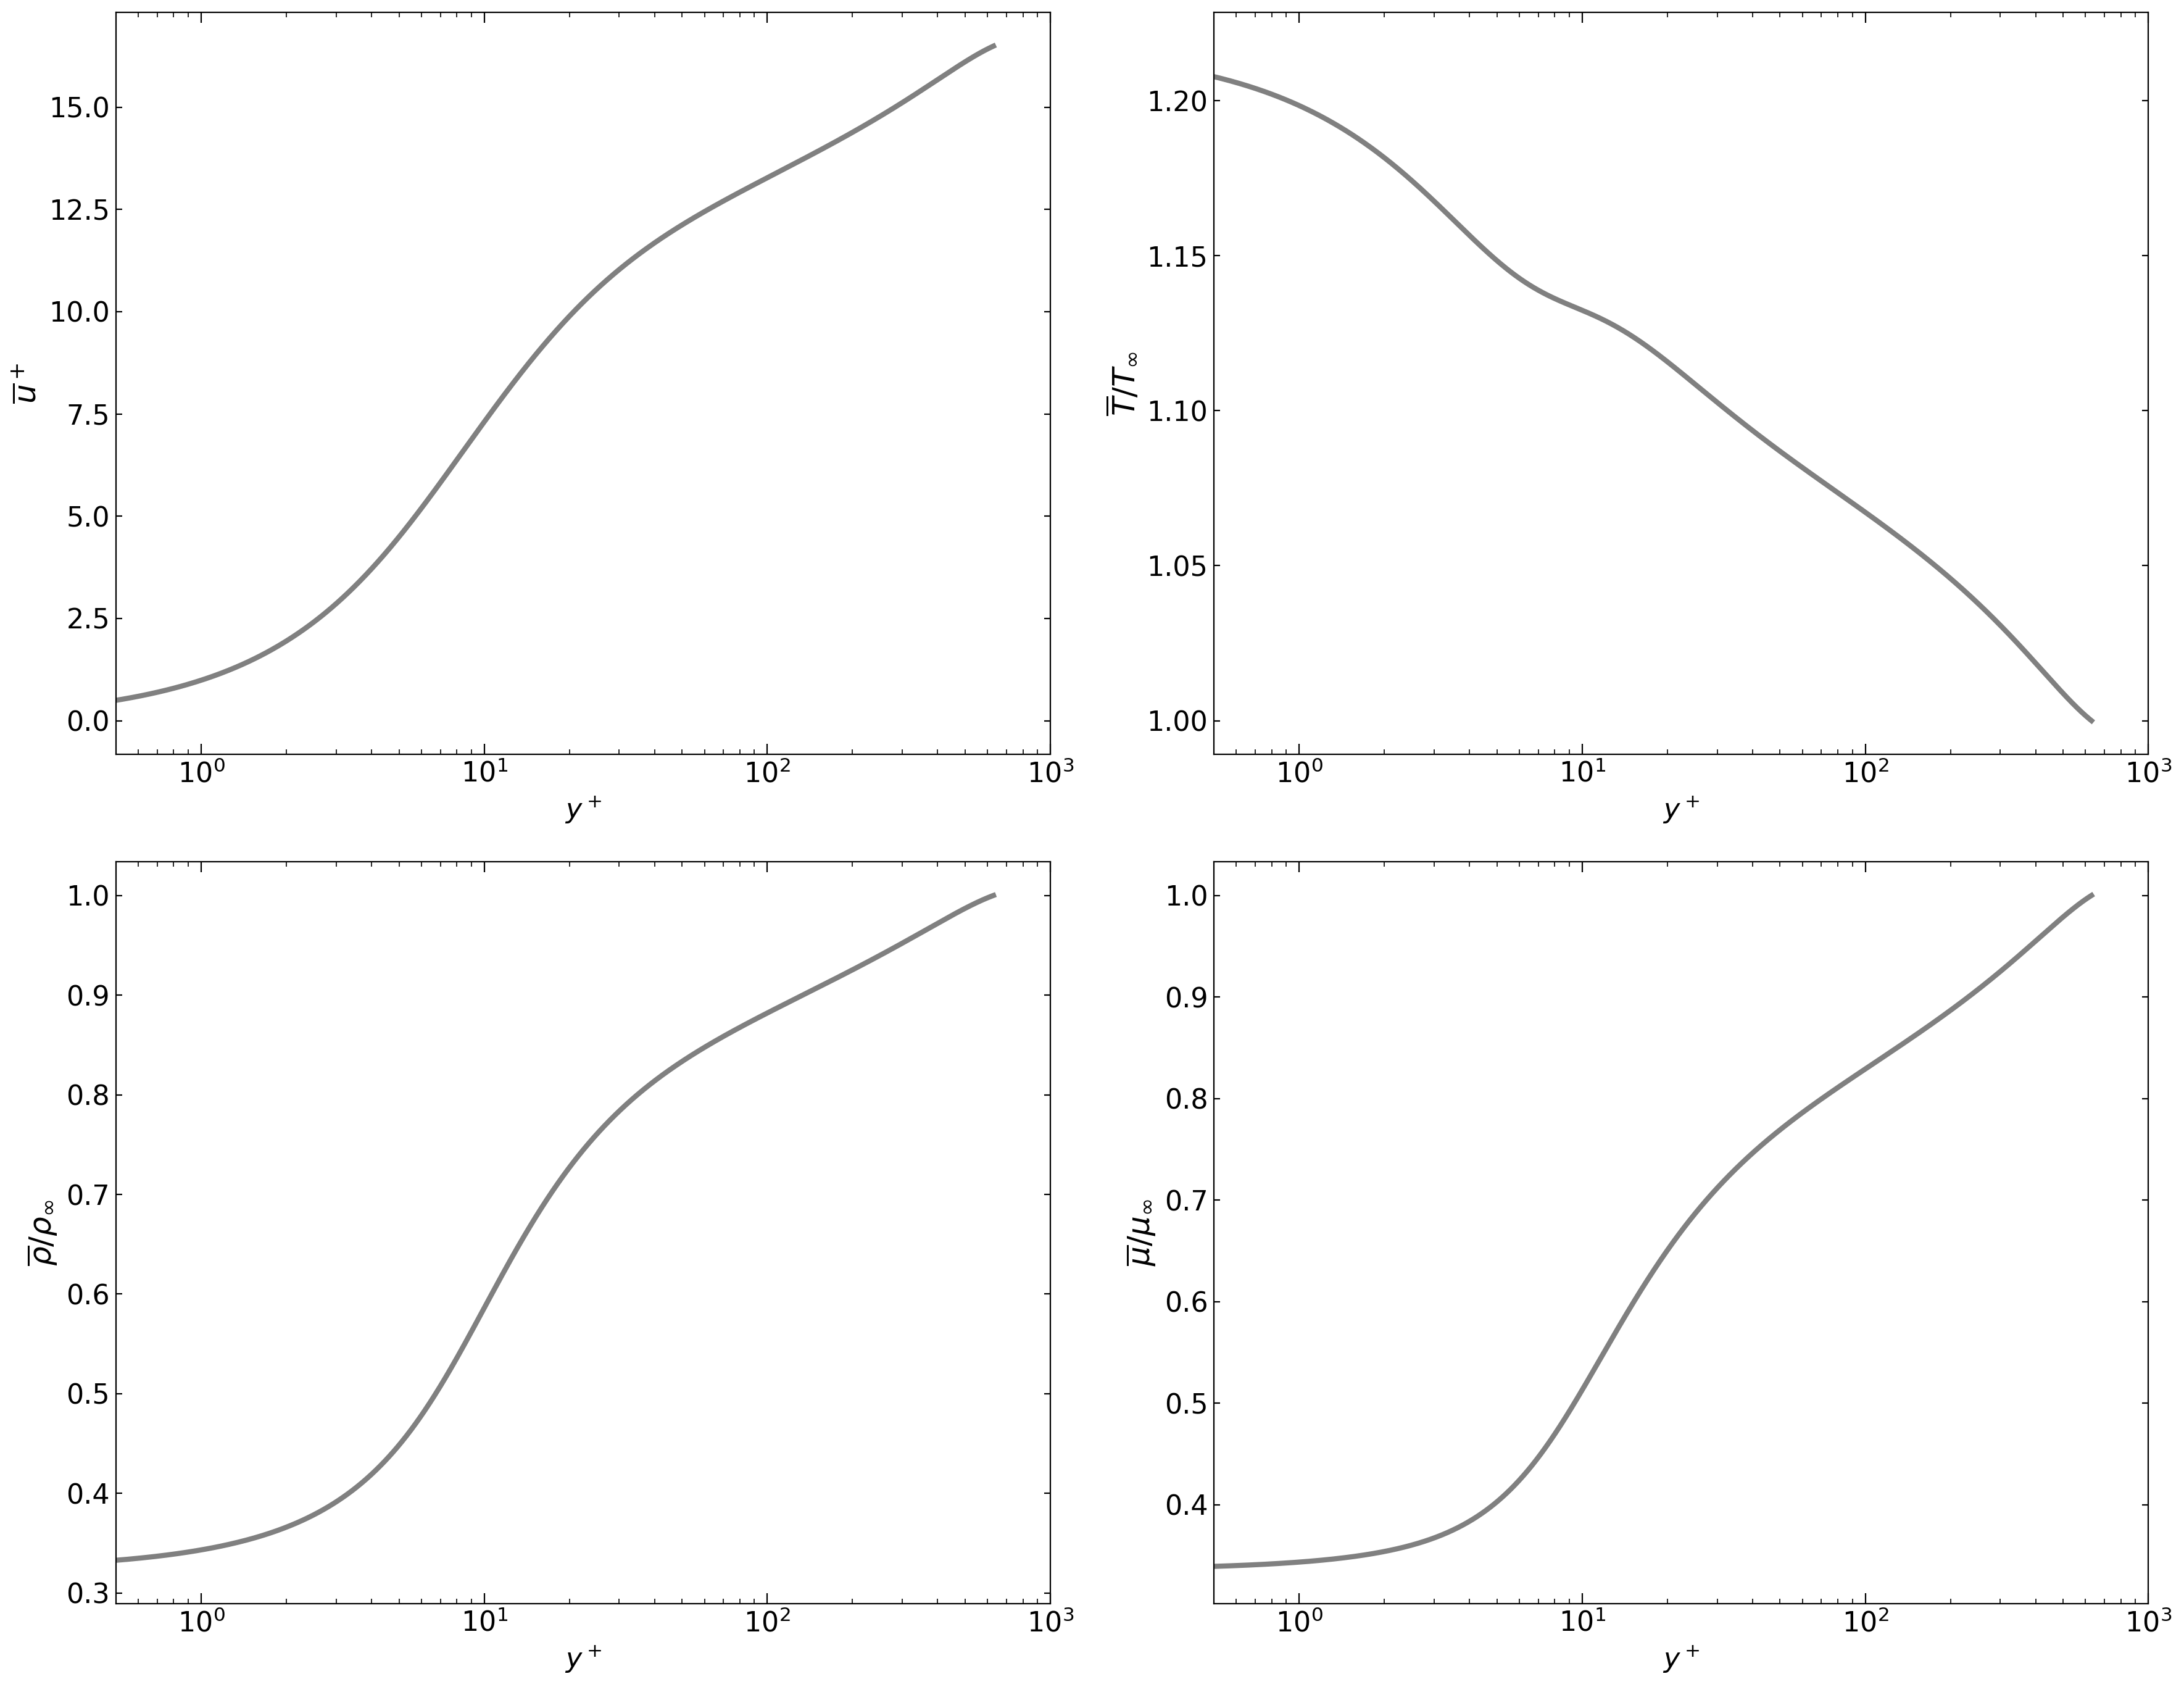

In [12]:
ReTheta        = 881
Minf           = 0.2
Prinf          = 1.0
Tw_Tinf        = 1.222
rw_rinf        = 0.321
Pref           = 1.10   
Tref           = 0.9
Cvref          = 4.5
entvelLaw      = "Walz"

cf, St, ReTau, MTau, ypl, yst, upl, T_Tw, r_rw, h_hw, mu_muw, ka_kaw  = \
                cfSt_solver(ReTheta   = ReTheta,
                            Minf      = Minf,
                            kappa     = 0.41,
                            Apl       = 17.0,
                            y_ye      = grid(nPoints = 2000, stretch = 5),
                            Tw_Tinf   = Tw_Tinf,
                            rw_rinf   = rw_rinf,
                            Prinf     = Prinf,
                            Pref      = Pref,
                            Tref      = Tref,
                            Cvref     = Cvref,
                            entvelLaw = entvelLaw,
                            verbose   = True)  

print('\nResult: cf = {0:.5e}, St = {1:.5e}, ReTau = {2:.5f}, MTau = {3:.3e}'.
      format(cf, St, ReTau, MTau))

#################################################################################
#
# plot profiles
#
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
import matplotlib.ticker as ticker
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
rc('text', usetex=False)  # switch to True for latex font (might be slow)
rcParams.update({"xtick.major.size": 6, "xtick.minor.size": 3, "ytick.minor.size": 6, "ytick.minor.size": 3, 
                 'xtick.direction': 'in', 'ytick.direction': 'in', 'xtick.top': True, 'ytick.right': True, 
                 'font.size': 16})

fig, ax = plt.subplots(2, 2, figsize=(18, 14))
plt.rcParams["text.usetex"] = True
linwid=3.0
ylim=1e3
ax[0,0].semilogx(ypl, upl, '-', lw=linwid, color='gray')
ax[0,0].set_xlim(0.5e0, ylim)
ax[0,0].set_ylabel(r"$\overline{u}^+$",  fontsize = 18)
ax[0,0].set_xlabel(r"$y^+$")

ax[0,1].semilogx(ypl, T_Tw/T_Tw[-1], '-', lw=linwid, color='gray')
ax[0,1].set_xlim(0.5e0, ylim)
ax[0,1].set_ylabel(r"$\overline{T}/T_{\infty}$",  fontsize = 18)
ax[0,1].set_xlabel(r"$y^+$")

ax[1,0].semilogx(ypl, r_rw/r_rw[-1], '-', lw=linwid, color='gray')
ax[1,0].set_xlim(0.5e0, ylim)
ax[1,0].set_ylabel(r"$\overline{\rho}/\rho_{\infty}$",  fontsize = 18)
ax[1,0].set_xlabel(r"$y^+$")

ax[1,1].semilogx(ypl, mu_muw/mu_muw[-1], '-', lw=linwid, color='gray')
ax[1,1].set_xlim(0.5e0, ylim)
ax[1,1].set_ylabel(r"$\overline{\mu}/\mu_{\infty}$",  fontsize = 18)
ax[1,1].set_xlabel(r"$y^+$")

fig.tight_layout()
plt.show()